In [1]:
### Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from diffpy.mpdf import *
from diffpy.Structure import loadStructure

### Set all plots to be inline
%matplotlib notebook

# Perform a simple mPDF fit to MnO

### Load the data into a Profile object

In [2]:
PDFguiFile = 'MnOpdfgui.ddp'
r,d = getDiffData(PDFguiFile, 0) ### extract the fit residual from the atomic PDF fit done in PDFgui

from diffpy.srfit.fitbase import Profile

profile = Profile()
profile.setObservedProfile(r, d)

### Make the magnetic structure

/home/ben/anaconda/envs/mpdfdev/lib/python2.7/site-packages/diffpy.Structure-1.3.2-py2.7.egg/diffpy/Structure/lattice.py:125: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if [a, b, c, alpha, beta, gamma, base] == 7*[None]:


<IPython.core.display.Javascript object>


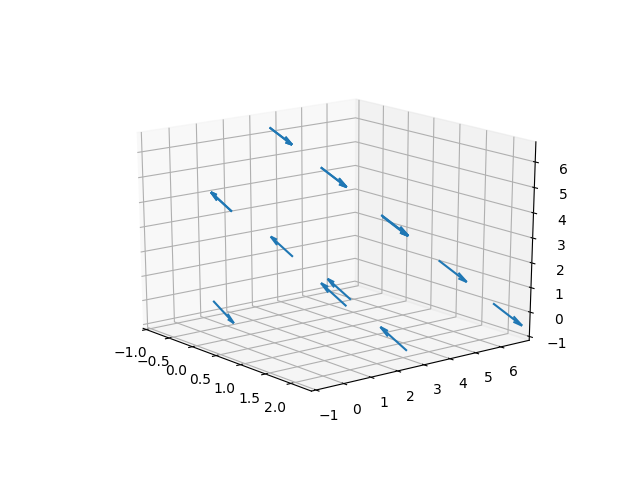

In [3]:
struc = getStrucFromPDFgui(PDFguiFile,0)

svec = np.array([1.0,-1.0,0.0])
msp = MagSpecies(struc,magIdxs=[0,1,2,3],ffparamkey='Mn2',rmaxAtoms=50,basisvecs=svec,
                kvecs=np.array([0.5,0.5,0.5]),label=str(0))

mstr=MagStructure()
mstr.loadSpecies(msp)
mstr.makeAll()

### Visualize the magnetic structure
uc = struc[:4].xyz
visatoms = uc.copy()
visatoms = np.concatenate((visatoms,visatoms+np.array([0,0,1]),visatoms+np.array([0,1,0]),visatoms+np.array([0,0,1])))
visatoms = struc.lattice.cartesian(visatoms)
visspins = mstr.spinsFromAtoms(visatoms,fractional=False)
mstr.visualize(visatoms,visspins)

### Make the MPDFcalculator

In [4]:
mc = MPDFcalculator(mstr,rmin=r.min(),rmax=r.max())

desired calculation range.


### Set up and perform the fit

In [5]:
### Make the FitContribution

from diffpy.srfit.fitbase import FitContribution
mfit = FitContribution('mfit')
mfit.setProfile(profile)

# Define the function that will calculate the mPDF
def mpdf(parascale, ordscale, damp):
    mc.paraScale, mc.ordScale, mc.dampRate = parascale, ordscale, damp
    dr = mc.calc(both=True)[2]
    return dr

mfit.registerFunction(mpdf)
mfit.setEquation("mpdf(parascale, ordscale, damp)")

In [6]:
### Make the FitRecipe and add the relevant variables
from diffpy.srfit.fitbase import FitRecipe
recipe = FitRecipe()

# give the PDFContribution to the FitRecipe
recipe.addContribution(mfit)

# add the mPDF variables
recipe.addVar(mfit.parascale, 4)
recipe.addVar(mfit.ordscale, 0.5)
recipe.addVar(mfit.damp, 0.01)

In [7]:
### Run the refinement

# Turn off printout of iteration number.
recipe.clearFitHooks()

# Initial structural fit
print "Refine using scipy's least-squares optimizer:"
print "  variables:", recipe.names
print "  initial values:", recipe.values

from scipy.optimize import least_squares

least_squares(recipe.residual, recipe.values)
print "  final values:", recipe.values

Refine using scipy's least-squares optimizer:
  variables: ['parascale', 'ordscale', 'damp']
  initial values: [ 4.    0.5   0.01]
  final values: [ 2.8959563   1.23062246  0.00673758]


### Plot the result

<IPython.core.display.Javascript object>


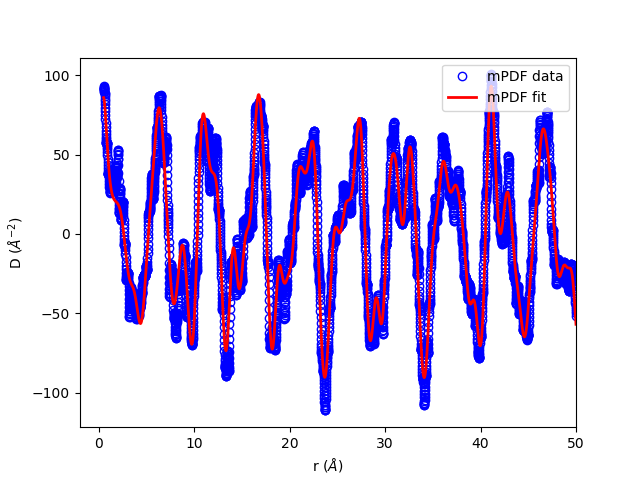

In [8]:
gcalc = mfit.evaluateEquation("mpdf")

# Plot just the mPDF
ax=plt.figure().add_subplot(111)
ax.plot(r, d, 'bo', label="mPDF data", markerfacecolor='none', markeredgecolor='b')
ax.plot(r, gcalc, 'r-', lw=2, label="mPDF fit")
ax.set_xlabel(r"r ($\AA$)")
ax.set_ylabel(r"D ($\AA^{-2}$)")
ax.set_xlim(xmax=mc.rmax)
plt.legend(loc=1)

plt.show()

In [11]:
plt.close('all')

Now refine spin direction

### Load the data into a Profile object

In [13]:
PDFguiFile = 'MnOpdfgui.ddp'
r,d = getDiffData(PDFguiFile, 0) ### extract the fit residual from the atomic PDF fit done in PDFgui

from diffpy.srfit.fitbase import Profile

profile = Profile()
profile.setObservedProfile(r, d)

### Make the magnetic structure

<IPython.core.display.Javascript object>


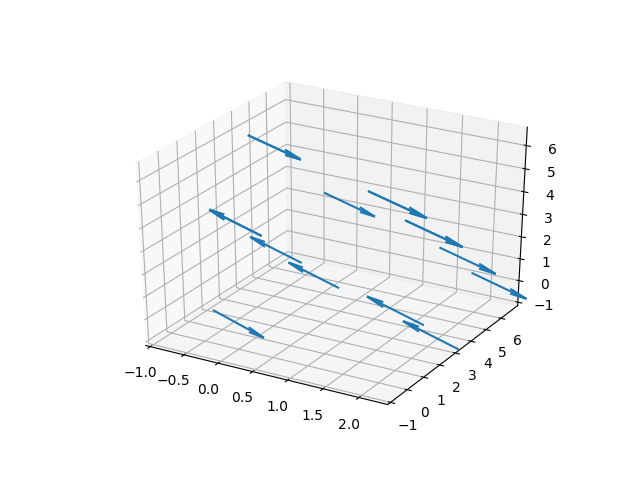

In [14]:
struc = getStrucFromPDFgui(PDFguiFile,0)

svec = np.array([1.0,-1.0,0.0])
msp = MagSpecies(struc,magIdxs=[0,1,2,3],ffparamkey='Mn2',rmaxAtoms=50,basisvecs=svec,
                kvecs=np.array([0.5,0.5,0.5]),label=str(0))

mstr=MagStructure()
mstr.loadSpecies(msp)
mstr.makeAll()

upMask = (np.apply_along_axis(np.linalg.norm,1,mstr.spins-svec)<0.01)
downMask = ~upMask

### Visualize the magnetic structure
uc = struc[:4].xyz
visatoms = uc.copy()
visatoms = np.concatenate((visatoms,visatoms+np.array([0,0,1]),visatoms+np.array([0,1,0]),visatoms+np.array([0,0,1])))
visatoms = struc.lattice.cartesian(visatoms)
visspins = mstr.spinsFromAtoms(visatoms,fractional=False)
mstr.visualize(visatoms,visspins)

### Make the MPDFcalculator

In [15]:
mc = MPDFcalculator(mstr)
mc.rmin = r.min()
mc.rmax = r.max()

### Set up and perform the fit

In [16]:
from diffpy.srfit.fitbase import FitContribution
mfit = FitContribution('mfit')
mfit.setProfile(profile)

In [17]:
# Define an mPDF function that will be added to the total PDF calculator
def mpdf(parascale, ordscale, damp, th, phi):
    mc.paraScale, mc.ordScale, mc.dampRate = parascale, ordscale, damp
    newvec = np.array([np.sin(th)*np.cos(phi),np.sin(th)*np.sin(phi),np.cos(th)])
    mstr.spins[upMask] = newvec
    mstr.spins[downMask] = -newvec
    dr = mc.calc(both=True)[2]
    return dr

mfit.registerFunction(mpdf)
mfit.setEquation("mpdf(parascale, ordscale, damp, th, phi)")

In [18]:
from diffpy.srfit.fitbase import FitRecipe
recipe = FitRecipe()

# give the PDFContribution to the FitRecipe
recipe.addContribution(mfit)

In [19]:
# add the mPDF variables
recipe.addVar(mfit.parascale, 4)
recipe.addVar(mfit.ordscale, 0.5)
recipe.addVar(mfit.damp, 0.01)
recipe.addVar(mfit.th, 0.5)
recipe.addVar(mfit.phi, 0.5)

In [20]:
# Turn off printout of iteration number.
recipe.clearFitHooks()

# Initial structural fit
print "Refine using scipy's least-squares optimizer:"
print "  variables:", recipe.names
print "  initial values:", recipe.values

from scipy.optimize import least_squares

least_squares(recipe.residual, recipe.values, bounds=[[0,0,0,0,-np.pi],[5,5,1,np.pi,np.pi]])
print "  final values:", recipe.values

Refine using scipy's least-squares optimizer:
  variables: ['parascale', 'ordscale', 'damp', 'th', 'phi']
  initial values: [ 4.    0.5   0.01  0.5   0.5 ]
  final values: [ 2.89532246  2.46122465  0.00673799  0.76372883 -1.60427272]


### Plot the result

<IPython.core.display.Javascript object>


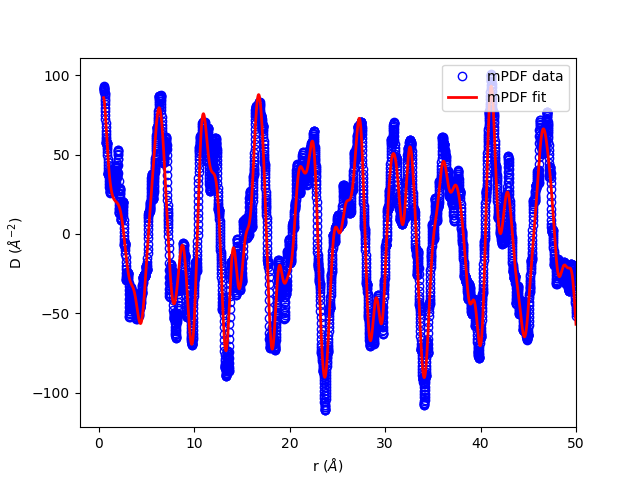

In [21]:
gcalc = mfit.evaluateEquation("mpdf")

# Plot just the mPDF
ax=plt.figure().add_subplot(111)
ax.plot(r, d, 'bo', label="mPDF data", markerfacecolor='none', markeredgecolor='b')
ax.plot(r, gcalc, 'r-', lw=2, label="mPDF fit")
ax.set_xlabel(r"r ($\AA$)")
ax.set_ylabel(r"D ($\AA^{-2}$)")
ax.set_xlim(xmax=mc.rmax)
plt.legend(loc=1)

plt.show()

In [ ]:
plt.close('all')

In [41]:
mstr.spins[0]

array([-0.0231486 , -0.69123194,  0.72226211])

Now using the fitRecipe restraint function to place bounds

### Load the data into a Profile object

In [2]:
PDFguiFile = 'MnOpdfgui.ddp'
r,d = getDiffData(PDFguiFile, 0) ### extract the fit residual from the atomic PDF fit done in PDFgui

from diffpy.srfit.fitbase import Profile

profile = Profile()
profile.setObservedProfile(r, d)

### Make the magnetic structure

/home/ben/anaconda/envs/mpdfdev/lib/python2.7/site-packages/diffpy.Structure-1.3.2-py2.7.egg/diffpy/Structure/lattice.py:125: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if [a, b, c, alpha, beta, gamma, base] == 7*[None]:


<IPython.core.display.Javascript object>


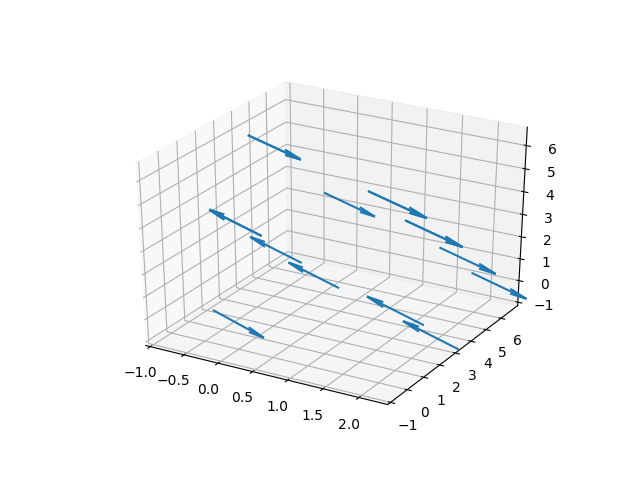

In [3]:
struc = getStrucFromPDFgui(PDFguiFile,0)

svec = np.array([1.0,-1.0,0.0])
msp = MagSpecies(struc,magIdxs=[0,1,2,3],ffparamkey='Mn2',rmaxAtoms=50,basisvecs=svec,
                kvecs=np.array([0.5,0.5,0.5]),label=str(0))

mstr=MagStructure()
mstr.loadSpecies(msp)
mstr.makeAll()

upMask = (np.apply_along_axis(np.linalg.norm,1,mstr.spins-svec)<0.01)
downMask = ~upMask

### Visualize the magnetic structure
uc = struc[:4].xyz
visatoms = uc.copy()
visatoms = np.concatenate((visatoms,visatoms+np.array([0,0,1]),visatoms+np.array([0,1,0]),visatoms+np.array([0,0,1])))
visatoms = struc.lattice.cartesian(visatoms)
visspins = mstr.spinsFromAtoms(visatoms,fractional=False)
mstr.visualize(visatoms,visspins)

### Make the MPDFcalculator

In [4]:
mc = MPDFcalculator(mstr)
mc.rmin = r.min()
mc.rmax = r.max()

### Set up and perform the fit

In [5]:
from diffpy.srfit.fitbase import FitContribution
mfit = FitContribution('mfit')
mfit.setProfile(profile)

In [6]:
# Define an mPDF function that will be added to the total PDF calculator
def mpdf(parascale, ordscale, damp, th, phi):
    mc.paraScale, mc.ordScale, mc.dampRate = parascale, ordscale, damp
    newvec = np.array([np.sin(th)*np.cos(phi),np.sin(th)*np.sin(phi),np.cos(th)])
    mstr.spins[upMask] = newvec
    mstr.spins[downMask] = -newvec
    dr = mc.calc(both=True)[2]
    return dr

mfit.registerFunction(mpdf)
mfit.setEquation("mpdf(parascale, ordscale, damp, th, phi)")

In [7]:
from diffpy.srfit.fitbase import FitRecipe
recipe = FitRecipe()

# give the PDFContribution to the FitRecipe
recipe.addContribution(mfit)

In [8]:
# add the mPDF variables
recipe.addVar(mfit.parascale, 4)
recipe.addVar(mfit.ordscale, 0.5)
recipe.addVar(mfit.damp, 0.01)
recipe.addVar(mfit.th, 0.5)
recipe.addVar(mfit.phi, 0.5)

In [9]:
thrst = recipe.restrain(recipe.th, lb=0, ub=np.pi, sig=0.0001) 
phirst = recipe.restrain(recipe.phi, lb=-np.pi, ub=np.pi, sig=0.0001) 

In [10]:
# Turn off printout of iteration number.
recipe.clearFitHooks()

# Initial structural fit
print "Refine using scipy's least-squares optimizer:"
print "  variables:", recipe.names
print "  initial values:", recipe.values

from scipy.optimize import least_squares

least_squares(recipe.residual, recipe.values)
print "  final values:", recipe.values

Refine using scipy's least-squares optimizer:
  variables: ['parascale', 'ordscale', 'damp', 'th', 'phi']
  initial values: [ 4.    0.5   0.01  0.5   0.5 ]
  final values: [  3.98934342e+00   1.61286874e+00  -6.71623536e-04  -2.28116068e-02
   4.48462494e-01]


### Plot the result

<IPython.core.display.Javascript object>


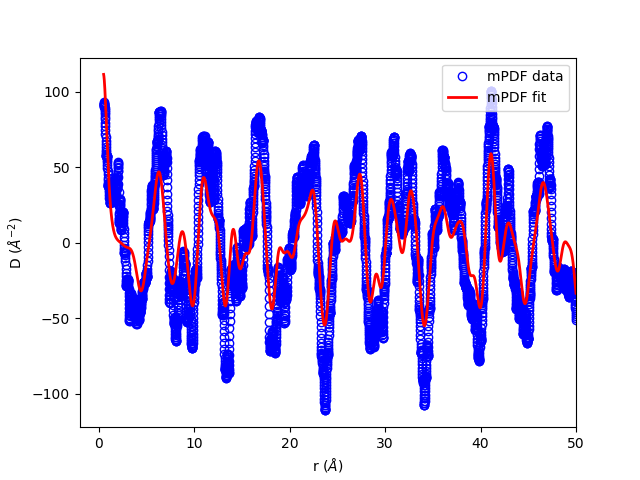

In [11]:
gcalc = mfit.evaluateEquation("mpdf")

# Plot just the mPDF
ax=plt.figure().add_subplot(111)
ax.plot(r, d, 'bo', label="mPDF data", markerfacecolor='none', markeredgecolor='b')
ax.plot(r, gcalc, 'r-', lw=2, label="mPDF fit")
ax.set_xlabel(r"r ($\AA$)")
ax.set_ylabel(r"D ($\AA^{-2}$)")
ax.set_xlim(xmax=mc.rmax)
plt.legend(loc=1)

plt.show()

In [12]:
plt.close('all')

The restraints do not work very well!!! Maybe discuss with Pavol?